On 1-Dec-2020, the S&P500 (SPX) index value was 3662.45, while the SPDR
S&P500 Exchange Traded Fund (SPY) stock price was 366.02. The call and
put option prices (bid & offer) over 3 maturities are provided in the
spreadsheet:
• SPX options.csv
• SPY options.csv
The discount rate on this day is in the file: zero rates 20201201.csv.
Calibrate the following models to match the option prices:
1 Displaced-diffusion model
2 SABR model (fix β = 0.7)
Plot the fitted implied volatility smile against the market data.
Report the model parameters:
1 σ, β
2 α, ρ, ν
And discuss how does change β in the displaced-diffusion model and ρ, ν in the
SABR model affect the shape of the implied volatility

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, least_squares
import matplotlib.pylab as plt
import math

First, we shall implement the SABR model. The implied Black volatility of the SABR model is given by

\begin{equation}
\sigma_{\text{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) = \frac{\alpha}{(F_0K)^{(1-\beta)/2} \left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots \right\} } 
\cdot \frac{z}{x(z)} \cdot \left\{ 1 + \left[ \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(F_0K)^{1-\beta}} + \frac{1}{4} \frac{\rho \beta \nu \alpha}{(F_0K)^{(1-\beta)/2}} + \frac{2-3\rho^2}{24}\nu^2 \right] T + \cdots \right\},
\notag
\end{equation}

where

\begin{equation}
z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2} \log\left(\frac{F_0}{K}\right), \notag
\end{equation}

and

\begin{equation}
x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2} + z - \rho}{1 - \rho} \right]. \notag
\end{equation}


In [2]:
def calculate_displaced_diffusion_params(df, S, dict_ex_date_rate, impliedVolatility):
    dd_params = []

    for exdate, r in dict_ex_date_rate.items():
        # Filter for the current expiration date
        df_ex = df[df["exdate"] == exdate].copy()
        days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
        r = r/100
        T = days_to_expiry / 365
        F = S * np.exp(r * T)

        # Calculate Market implied volatilities
        df_ex['vols'] = df_ex.apply(lambda x: impliedVolatility(S, 
                                                                x['strike'], 
                                                                r, 
                                                                x['mid'], 
                                                                T, 
                                                                x['payoff']),
                                                                axis=1)
        df_ex.dropna(inplace=True)
        call_df = df_ex[df_ex['payoff'] == 'call']
        put_df = df_ex[df_ex['payoff'] == 'put']
        strikes = put_df['strike'].values
        impliedvols, option_prices, ls_payoff = [], [], []
        for K in strikes:    
            if K > S:
                impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
                option_prices.append(call_df[call_df['strike'] == K]['mid'].values[0])
                ls_payoff.append(call_df[call_df['strike'] == K]['payoff'].values[0])
            else:
                impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
                option_prices.append(put_df[put_df['strike'] == K]['mid'].values[0])
                ls_payoff.append(put_df[put_df['strike'] == K]['payoff'].values[0])

        df_iv = pd.DataFrame({'strike': strikes, 
                            'impliedvol': impliedvols,
                            'option_price': option_prices,
                            'payoff': ls_payoff})
        
        # finding ATM vol
        closest_strike = df_iv['strike'].iloc[(df_iv['strike'] - F).abs().idxmin()]
        spx_ATM_implied_vol = df_iv[df_iv['strike'] == closest_strike]['impliedvol'].values[0]

        # calibrate for optimal Beta
        initialGuess = [.5]        # beta
        res = least_squares(lambda x:ddcalibration(x, 
                                                option_prices, 
                                                spx_ATM_implied_vol,  
                                                strikes, 
                                                r,
                                                F, 
                                                T),
                            initialGuess,
                            bounds=(0,1))
        # store results
        dd_beta = res.x[0]
        dd_prices = DisplacedDiffusionPrice(dd_beta, spx_ATM_implied_vol, strikes, r, S, T)
        df_iv['dd_prices'] = dd_prices
        df_iv['dd_vols'] = df_iv.apply(lambda x: impliedVolatility(S, 
                                                                    x['strike'], 
                                                                    r, 
                                                                    x['dd_prices'], 
                                                                    T, 
                                                                    x['payoff']),
                                                                    axis=1)
        dd_params.append({'exdate': exdate, 'dd_beta': dd_beta, 'sig_atm': spx_ATM_implied_vol, 'dd_vols': list(df_iv['dd_vols'])})
        plt.figure(tight_layout=True)
        plt.title(f"{exdate} Market vs DD Implied Vol")
        plt.plot(strikes, df_iv['impliedvol'], 'gs', label='Market Implied Vols')
        plt.plot(strikes, df_iv['dd_vols'], 'm--', label=f'DD Implied Vols, beta={dd_beta:.3f}')
        plt.legend()
        plt.show()

    for params in dd_params:
        print(f"Exdate {params['exdate']}: beta = {params['dd_beta']:.5f}, sigma = {params['sig_atm']:.5f}")

    return dd_params

def ddcalibration(x, option_prices, ATM_iv, strikes, r, F, T) -> float:
    """
    Function to obtain total squared error between estimated (using parameters in x) and actual price

    Parameters:
        x: list of DD parameters with sigma, beta
        strikes: K,
        vols: list of market implied volatility,
        F: stock future price adjusted for T or [S*np.exp(r*T)]
        T: years to expiry

    Return:
        total error computed from list of vol provided
    """
    err = 0.0
    
    for i, price in enumerate(option_prices):
        F_dd = F / x[0]
        K_dd = strikes[i] + (1 - x[0]) / x[0] * F 

        if strikes[i] > F:
            est_price = BlackCall(F_dd, K_dd, r, ATM_iv * x[0], T)
        else:
            est_price = BlackPut(F_dd, K_dd, r, ATM_iv * x[0], T)
        
        err += (price - est_price)**2
    
    return err

def DisplacedDiffusionPrice(beta, ATM_iv, strikes, r, S, T) -> float:
    """
    Function to return prices of DD model

    Parameters:
        beta: dd beta
        strikes: K,
        vols: list of market implied volatility,
        S: stock spot px
        T: years to expiry

    Return:
        total error computed from list of vol provided
    """
    ls_price  = []
    F = S*np.exp(r*T)
    
    for strike in strikes:
        F_dd = F / beta
        K_dd = strike + ((1 - beta) / beta * F) 
        sig_dd = ATM_iv * beta

        if strike > S:
            est_price = BlackCall(F_dd, K_dd, r, sig_dd, T)
        else:
            est_price = BlackPut(F_dd, K_dd, r, sig_dd, T)
        
        ls_price.append(est_price)

    return ls_price

def BlackCall(F, K, r, sig, T)->tuple:
    """
    Calculate the Black model prices of European call and put options.

    Parameters:
    ----------
    F0 : float
        Current futures price.
    K : float
        Strike price of the option.
    T : float
        Time to expiration in years.
    r : float
        Risk-free interest rate (as a decimal).
    sig : float
        Volatility of the underlying asset (annualized).

    Returns:
    -------
    tuple
        A tuple containing the call option price and the put option price (call_price, put_price).
    """
    d1 = (math.log(F/K) +.5*(sig**2)*T) / \
          (sig*T**.5)
    d2 = (math.log(F/K) -.5*(sig**2)*T) / \
          (sig*T**.5)
    
    return math.exp(-r*T) * ( F*norm.cdf( d1) - K *norm.cdf( d2) )

def BlackPut(F, K, r, sig, T)->tuple:
    """
    Calculate the Black model prices of European call and put options.

    Parameters:
    ----------
    F0 : float
        Current futures price.
    K : float
        Strike price of the option.
    T : float
        Time to expiration in years.
    r : float
        Risk-free interest rate (as a decimal).
    sig : float
        Volatility of the underlying asset (annualized).

    Returns:
    -------
    tuple
        A tuple containing the call option price and the put option price (call_price, put_price).
    """
    d1 = (math.log(F/K) +.5*(sig**2)*T) / \
          (sig*T**.5)
    d2 = (math.log(F/K) -.5*(sig**2)*T) / \
          (sig*T**.5)
    
    return math.exp(-r*T) * ( K *norm.cdf(-d2) - F*norm.cdf(-d1) )
    

def preprocess_options_data(file_path):
    """
    Preprocess options data by calculating mid-price, scaling strike prices, 
    and mapping call/put flags.

    Parameters:
    - file_path (str): Path to the CSV file containing options data.

    Returns:
    - DataFrame: Processed options data with 'mid', 'strike', and 'payoff' columns.
    """
    df = pd.read_csv(file_path)
    df['mid'] = 0.5 * (df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price'] * 0.001  # Adjusting strike price scale
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    return df

def calculate_sabr_params(df, S, dict_ex_date_rate, impliedVolatility, sabrcalibration, SABR, beta=0.7):
    """
    Function to execute SABR parameter search based on option prices, rates, and beta.
    Prints out estimated SABR parameters for unique expiry dates in df

    Parameters:
        df: ticker data,
        df_rates: zero curve for annual vol with tenors in days column
        S: spot px
        impliedVolatility: function returning market implied vol
        SABR: function to return sigma for given parameters
        beta: fixed beta for SABR

    Return: 
        dictionary of SABR parameters and list of vols
    """
    # Initialize list to store SABR parameters for each expiration date
    sabr_params = []

    # Loop through each expiration date
    for exdate, r in dict_ex_date_rate.items():
        df_ex = df[df["exdate"] == exdate].copy()
        T = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days / 365
        r = r / 100
        F = S * np.exp(r * T)

        # Calculate implied volatilities
        df_ex['vols'] = df_ex.apply(lambda x: impliedVolatility(S, x['strike'], r, x['mid'], T, x['payoff']), axis=1)
        df_ex.dropna(inplace=True)

        # Filter and collect strikes and implied vols
        call_df, put_df = df_ex[df_ex['payoff'] == 'call'], df_ex[df_ex['payoff'] == 'put']
        strikes = put_df['strike'].values
        impliedvols = [
            call_df[call_df['strike'] == K]['vols'].values[0] 
                if K > S else put_df[put_df['strike'] == K]['vols'].values[0]
                    for K in strikes
        ]
        df_iv = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
        
        # Calibrate SABR parameters
        initialGuess = [.02, .2, .1]
        res = least_squares(lambda x: sabrcalibration(x, df_iv['strike'], df_iv['impliedvol'], F, T), initialGuess)
        alpha, rho, nu = res.x
        
        # Plot SABR vs Market implied volatilities
        sabrvols = [SABR(F, K, T, alpha, beta, rho, nu) for K in strikes]
        sabr_params.append({'exdate': exdate, 'alpha': alpha, 'rho': rho, 'nu': nu, 'vols': sabrvols})
        plt.figure(tight_layout=True)
        plt.title(f"{exdate} Market vs SABR Implied Vol")
        plt.plot(strikes, df_iv['impliedvol'], 'gs', label='Market Implied Vols')
        plt.plot(strikes, sabrvols, 'm--', label='SABR Implied Vols')
        plt.legend()
        plt.show()
    
    # Output calibrated SABR parameters
    for params in sabr_params:
        print(f"Exdate {params['exdate']}: alpha = {params['alpha']:.3f}, rho = {params['rho']:.3f}, nu = {params['nu']:.3f}")

    return sabr_params

def sabrcalibration(x, strikes, vols, F, T) -> float:
    """
    Function to obtain total squared error between estimated (using parameters in x) and actual given(vols) sigmas
    float

    Parameters:
        x: list of SABR parameters with alpha, rho, nu,
        strikes: K,
        vols: list of market implied volatility,
        F: stock future price adjusted for T or [S*np.exp(r*T)]
        T: years to expiry

    Return:
        total error computed from list of vol provided
    """
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    
    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def SABR(F, K, T, alpha, beta, rho, nu):
    """
    Use SABR model to return sigma 
    """

    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

## SABR functions and constants
beta = 0.7 # config for SABR modelbeta = 0.7 # config for SABR model
S_spx = 3662.45
S_spy = 366.02

In [3]:
# get market prices and prepare data
df_rates = pd.read_csv("zero_rates_20201201.csv")\
            .sort_values('days')

df_spx = preprocess_options_data("SPX_options.csv")
df_spy = preprocess_options_data("SPY_options.csv")

# rates data
exdates = sorted(df_spx['exdate'].unique())[:3].copy()
days_to_expiry = [(pd.Timestamp(str(date)) - pd.Timestamp('2020-12-01')).days \
                    for date in exdates]
arr_rates = np.interp(
                        days_to_expiry,df_rates['days'].values, 
                        df_rates['rate'].values,
                    )
dict_ex_date_rate = dict(zip(exdates, arr_rates))

# Displaced-Diffusion Model
## SPX

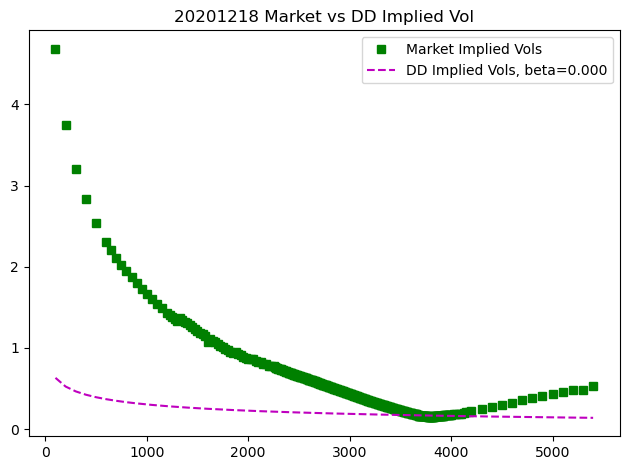

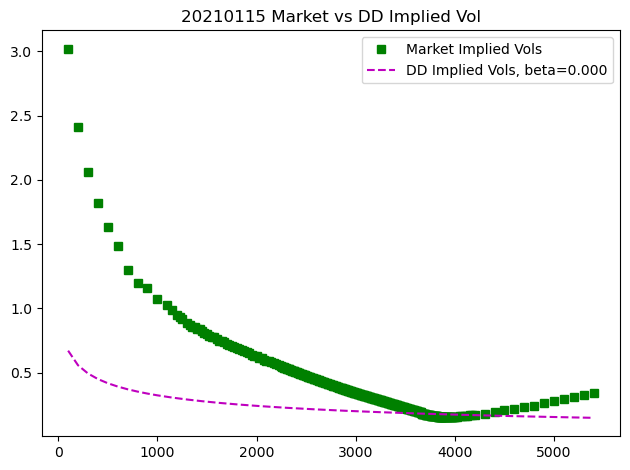

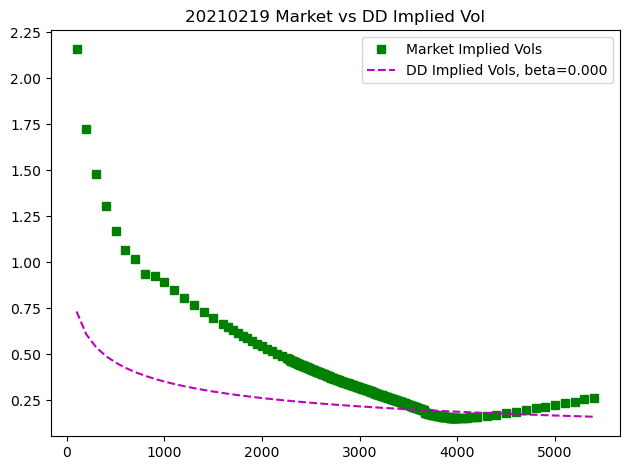

Exdate 20201218: beta = 0.00003, sigma = 0.17060
Exdate 20210115: beta = 0.00001, sigma = 0.18080
Exdate 20210219: beta = 0.00000, sigma = 0.19717


[{'exdate': 20201218,
  'dd_beta': 2.6876583512798804e-05,
  'sig_atm': 0.1706034570296796,
  'dd_vols': [0.631984834988955,
   0.5249594269740786,
   0.4651418593549402,
   0.4242534012083635,
   0.39354848131868697,
   0.36917735486942277,
   0.3586936077399407,
   0.3491089678058631,
   0.3402936613306883,
   0.33214358633293845,
   0.32457400570524597,
   0.31751506071146324,
   0.3109085035184524,
   0.30470528408414677,
   0.29886372788877014,
   0.2933481384085583,
   0.28812771580408403,
   0.28317571440411254,
   0.28079295322222325,
   0.27846876467141635,
   0.27620067045798813,
   0.2739863358780865,
   0.27182356543900094,
   0.26971029456751716,
   0.2676445724773102,
   0.2656245579266718,
   0.263648514570645,
   0.2617147950994984,
   0.2598218419853491,
   0.2579681809767774,
   0.2561524087725143,
   0.2543731991719826,
   0.2526292881169524,
   0.2509194746933649,
   0.2492426163158915,
   0.24759762337800972,
   0.2459834607202385,
   0.24439913829819895,
   0.2428

In [4]:
calculate_displaced_diffusion_params(df_spx, S_spx, dict_ex_date_rate, impliedVolatility)

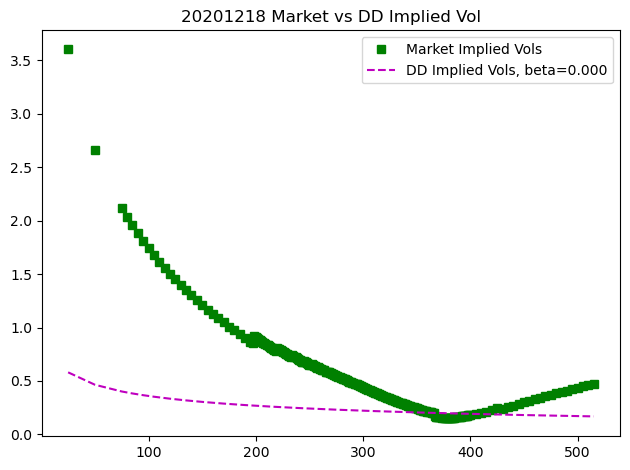

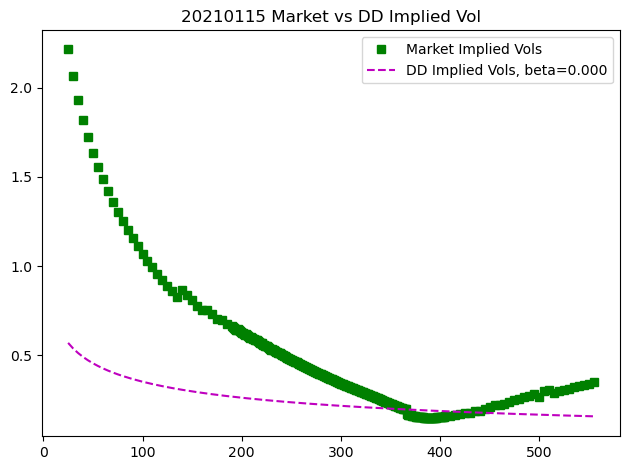

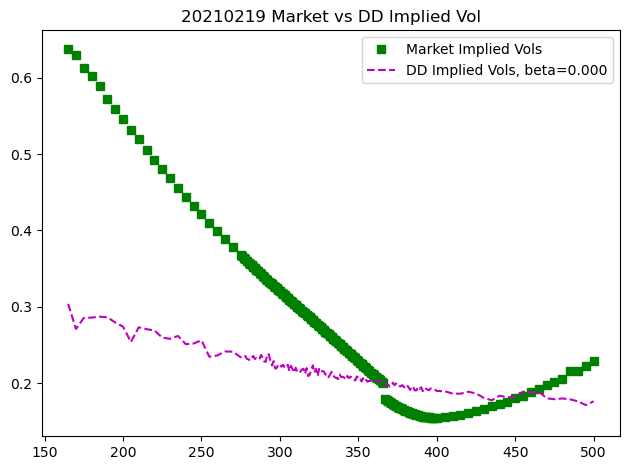

Exdate 20201218: beta = 0.00000, sigma = 0.20155
Exdate 20210115: beta = 0.00000, sigma = 0.19777
Exdate 20210219: beta = 0.00000, sigma = 0.20065


[{'exdate': 20201218,
  'dd_beta': 2.48363579521965e-09,
  'sig_atm': 0.201551377306335,
  'dd_vols': [0.5809446386453712,
   0.4648898303865483,
   0.40195715034327933,
   0.39233674257402823,
   0.38339079221576683,
   0.37504244203955217,
   0.3672459963894464,
   0.3599203772862201,
   0.35301086257873104,
   0.3464977808807042,
   0.3403221995684619,
   0.33446945977458165,
   0.3289264383295966,
   0.32361991963595343,
   0.31857161269541145,
   0.31375129151100617,
   0.30912421671746176,
   0.30470468846843474,
   0.30044939828653683,
   0.2963698670876155,
   0.2924494691996338,
   0.2886654339171929,
   0.28502409888241254,
   0.28151125551905815,
   0.2781252887473567,
   0.27484205640510234,
   0.2716689622595201,
   0.27104673485524405,
   0.27042854441971426,
   0.269815851694241,
   0.26919895681339606,
   0.26859751292577144,
   0.26798961300319474,
   0.26739068611924577,
   0.2667991187502056,
   0.26620755976812677,
   0.2656181452157525,
   0.2650392117721265,
   0.

In [5]:
calculate_displaced_diffusion_params(df_spy, S_spy, dict_ex_date_rate, impliedVolatility)

# SABR model

## SPX

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_10230/1598329036.py:330: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_10230/1598329036.py:330: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


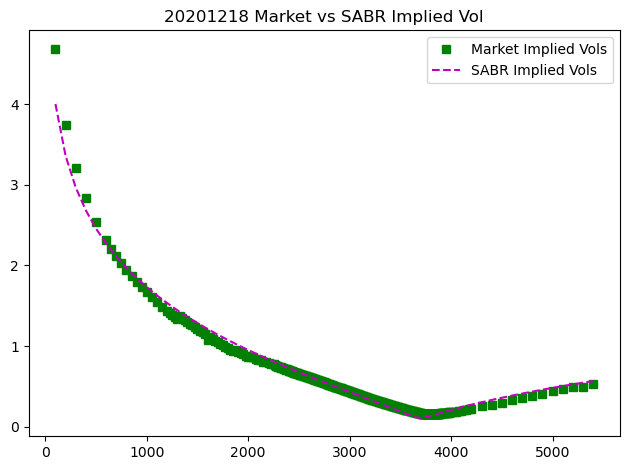

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_10230/1598329036.py:330: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_10230/1598329036.py:330: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


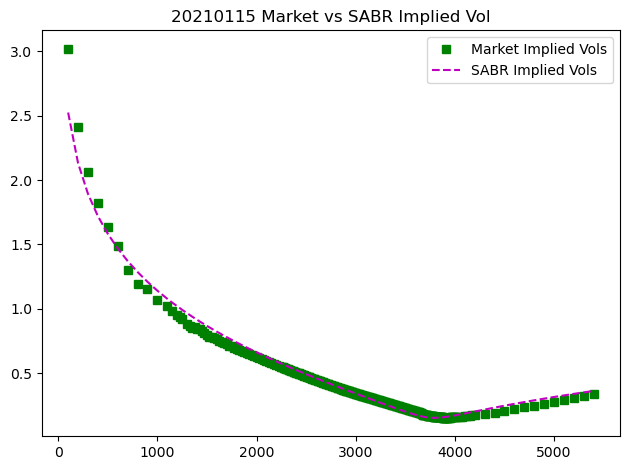

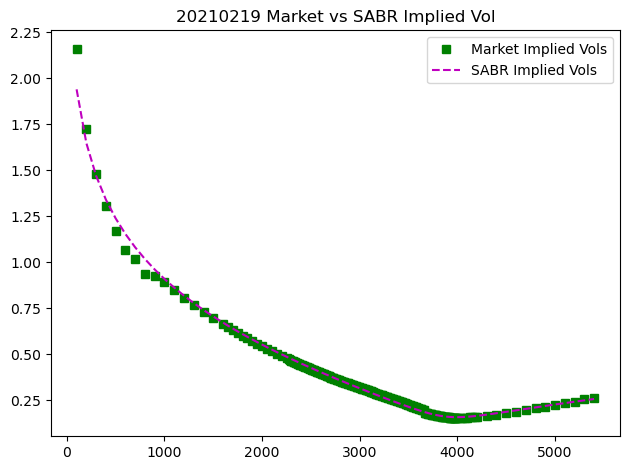

Exdate 20201218: alpha = 1.212, rho = -0.301, nu = 5.460
Exdate 20210115: alpha = 1.817, rho = -0.404, nu = 2.790
Exdate 20210219: alpha = 2.140, rho = -0.575, nu = 1.842


[{'exdate': 20201218,
  'alpha': 1.2122899461943184,
  'rho': -0.3009002533367289,
  'nu': 5.459761437735651,
  'vols': [4.0003596530620165,
   3.3567371826508845,
   2.9650718321965335,
   2.680335293536268,
   2.4554176494374245,
   2.268872520915424,
   2.1861450489905265,
   2.1090783408500116,
   2.0369072340901924,
   1.969011819207481,
   1.9048826986777823,
   1.8440960650960483,
   1.786295441195582,
   1.7311780499196103,
   1.678484471469219,
   1.6279906782761608,
   1.5795018195170092,
   1.5328473125173707,
   1.5101602888736647,
   1.4878769238748581,
   1.4659810999298495,
   1.4444576095032589,
   1.4232920863825906,
   1.402470943272996,
   1.381981315029348,
   1.361811006921574,
   1.3419484474032704,
   1.3223826449174472,
   1.3031031483284858,
   1.2841000106171863,
   1.2653637555173292,
   1.246885346808381,
   1.2286561600105037,
   1.2106679562557034,
   1.1929128581331292,
   1.1753833273278391,
   1.1580721438910395,
   1.1409723869963588,
   1.124077417051

In [6]:
calculate_sabr_params(df_spx, S_spx, dict_ex_date_rate, impliedVolatility, sabrcalibration, SABR, beta=0.7)

## SPY

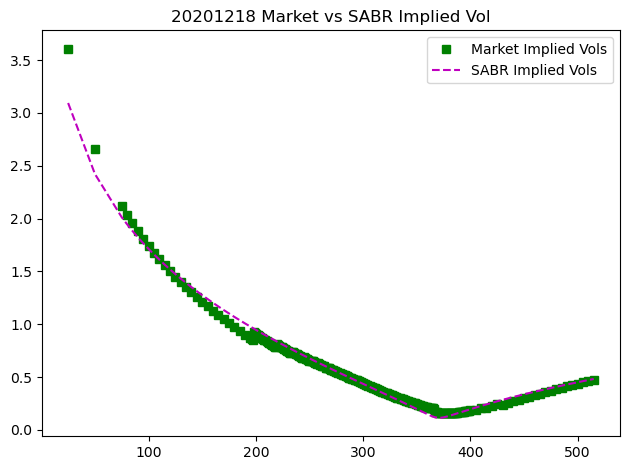

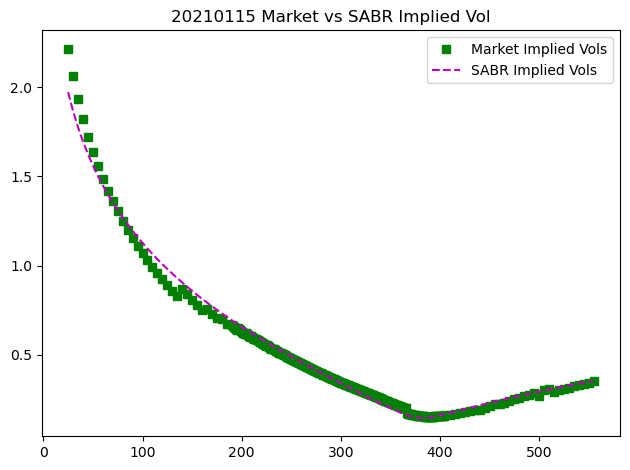

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_10230/1598329036.py:330: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


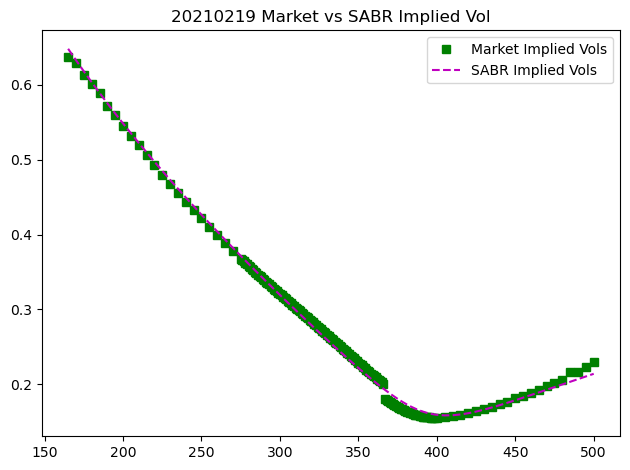

Exdate 20201218: alpha = 0.665, rho = -0.412, nu = 5.250
Exdate 20210115: alpha = 0.908, rho = -0.489, nu = 2.729
Exdate 20210219: alpha = 1.121, rho = -0.633, nu = 1.742


[{'exdate': 20201218,
  'alpha': 0.6654021766155193,
  'rho': -0.41189985520018163,
  'nu': 5.2499814542603485,
  'vols': [3.0936264728062794,
   2.4213512331301503,
   2.011754152506836,
   1.9452880731461417,
   1.8825037305362464,
   1.822986688906391,
   1.7663883521895811,
   1.712412634900118,
   1.66080584756588,
   1.6113489076566967,
   1.5638512614548,
   1.5181460839640715,
   1.4740864466754322,
   1.431542227478949,
   1.3903975961543842,
   1.3505489509232886,
   1.311903211872023,
   1.274376399211783,
   1.237892440724694,
   1.2023821649934803,
   1.1677824462635156,
   1.1340354738399978,
   1.101088124348364,
   1.0688914193925492,
   1.0374000544307818,
   1.0065719872709729,
   0.9763680766291216,
   0.9703989338990862,
   0.9644530067638366,
   0.958530017869561,
   0.9526296933639553,
   0.9467517628152586,
   0.9408959591330037,
   0.9350620184904154,
   0.9292496802484083,
   0.9234586868811203,
   0.9176887839029343,
   0.9119397197969312,
   0.906211245944723

In [7]:
calculate_sabr_params(df_spy, S_spy, dict_ex_date_rate, impliedVolatility, sabrcalibration, SABR, beta=0.7)